In [2]:
import numpy as np
from scipy.sparse import csc_matrix
from typing import Tuple, List, Callable
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import RectBivariateSpline
from linear_solver import solve
from sympy import symbols, Eq
from sympy import expand, simplify
import sympy
from numbers import Number
from typing import Literal, Union

from sympy import Lambda
    

Matplotlib is building the font cache; this may take a moment.


In [ ]:







import os


class ConvectionDiffusionSolver:
    
    scheme: Literal["central_difference", "upwind", "hybrid", "SIMPLE"] = "central_difference"
    L_x:        float=1,
    L_y:        float=1,
    n_rows:     int=10,
    n_cols:     int=10,
    params = {}
     
    (phi_x_0, phi_x_L, phi_y_0,  phi_y_L,  phi_E, phi_W, phi_N, phi_S, phi_P, u_x, u_y, gamma, delta_x, delta_y) = symbols('\phi_{x_0}  phi_{x_L} \phi_{y_0} \phi_{y_L} \phi_E \phi_W \phi_N \phi_S \phi_P u_x u_y \Gamma \delta_x \delta_y')
    
    # __u_x__: Lambda
    # __u_y__: Lambda
    
    x, y = symbols("x y")
    
    A_data: np.ndarray
    A_rows: np.ndarray
    A_cols: np.ndarray

    _A: csc_matrix
    _b: np.ndarray
    _x: np.ndarray
    
    error: float
    
    
    def __init__(self, 
        L_x:        float=1,
        L_y:        float=1,
        n_rows:     int=10,
        n_cols:     int=10,
        phi_x_0:     float=100,
        phi_x_L:     float=0,
        phi_y_0:     float=0,
        phi_y_L:     float=100,
        gamma:       float=1,
        u_x:         Number | sympy.Expr =2,
        u_y:         Number | sympy.Expr =2,
        scheme:      Literal["central_difference", "upwind", "hybrid", "SIMPLE"] = "central_difference"
        ):
        self.scheme = scheme
        self.L_x        = L_x
        self.L_y        = L_y
        self.n_rows     = n_rows
        self.n_cols     = n_cols
        
        self.params = {
            self.phi_x_0: phi_x_0,
            self.phi_x_L: phi_x_L,
            self.phi_y_0: phi_y_0,
            self.phi_y_L: phi_y_L,
            self.gamma: gamma,
            self.u_x: u_x,
            self.u_y: u_y,
            self.delta_x: L_x / n_cols,
            self.delta_y: L_y / n_rows
        }
        
        N = n_rows * n_cols
        num_nonzero = 5 * N - 2 * n_cols - 2 * n_rows


        self.A_data = np.zeros((num_nonzero)).astype(np.float64)
        self.A_rows = np.zeros((num_nonzero), dtype=np.int64)
        self.A_cols = np.zeros((num_nonzero), dtype=np.int64)

        self._b = np.zeros((n_rows * n_cols, 1)).astype(np.float64)
       
        if self.scheme == "central_difference":
            self.get_phi_e = (self.phi_E + self.phi_P) / 2
            self.get_phi_w = (self.phi_W + self.phi_P) / 2
            self.get_phi_n = (self.phi_N + self.phi_P) / 2
            self.get_phi_s = (self.phi_S + self.phi_P) / 2
        elif self.scheme == "upwind":
            if isinstance(self.params[self.u_x], Number):
                self.get_phi_e = self.phi_P if self.params[self.u_x] >= 0 else self.phi_E
                self.get_phi_w = self.phi_W if self.params[self.u_x] >= 0 else self.phi_P 
            else:
                self.get_phi_e = sympy.Piecewise(
                    (self.phi_P, self.u_x >= 0),
                    (self.phi_E, self.u_x < 0))
                self.get_phi_w = sympy.Piecewise(
                    (self.phi_W, self.u_x >= 0),
                    (self.phi_P, self.u_x < 0))
            if isinstance(self.params[self.u_y], Number):
                self.get_phi_n = self.phi_P if self.params[self.u_y] >= 0 else self.phi_N
                self.get_phi_s = self.phi_S if self.params[self.u_y] >= 0 else self.phi_P
            else: 
                self.get_phi_n = sympy.Piecewise(
                    (self.phi_P, self.u_y >= 0),
                    (self.phi_N, self.u_y < 0))
                self.get_phi_s = sympy.Piecewise(
                    (self.phi_S, self.u_y >= 0),
                    (self.phi_P, self.u_y < 0))
                
            
            
        self.get_d_phi_e = (self.phi_E - self.phi_P) / self.delta_x
        self.get_d_phi_w = (self.phi_P - self.phi_W) / self.delta_x
        self.get_d_phi_n = (self.phi_N - self.phi_P) / self.delta_y
        self.get_d_phi_s = (self.phi_P - self.phi_S) / self.delta_y
        
        self.F_e = u_x
        self.F_w = u_x
        self.F_n = u_y
        self.F_s = u_y
        self.F_Be = u_x 
        self.F_Bw = u_x
        self.F_Bn = u_y
        self.F_Bs = u_y
        self.D_e = self.gamma / self.delta_x
        self.D_w = self.gamma / self.delta_x
        self.D_n = self.gamma / self.delta_y
        self.D_s = self.gamma / self.delta_y
        self.D_Be = gamma / self.delta_x 
        self.D_Bw = gamma / self.delta_x
        self.D_Bn = gamma / self.delta_y
        self.D_Bs = gamma / self.delta_y

        
        
    
    def construct_problem(self):
        
        # +--------+-------------------------------+--------+
        # |        |                               |        |
        # |    G   |               H               |    I   |
        # |        |                               |        |
        # |--------|-------------------------------|--------|
        # |        |                               |        |
        # |        |                               |        |
        # |        |                               |        |
        # |        |                               |        |
        # |        |                               |        |
        # |    D   |               E               |    F   |
        # |        |                               |        |
        # |        |                               |        |
        # |        |                               |        |
        # |        |                               |        |
        # |--------|-------------------------------|--------|
        # |        |                               |        |
        # |   A    |               B               |   C    |
        # |        |                               |        |
        # +--------+-------------------------------+--------+
        


        self.setAExpr()
        self.setBExpr()
        self.setCExpr()
        self.setDExpr()
        self.setEExpr()
        self.setFExpr()
        self.setGExpr()
        self.setHExpr()
        self.setIExpr()
        
        
        idx = [0]
        self.set_arrays(self.A_expr, 0, idx)
        
        for i in range(1, self.n_cols - 1):
            self.set_arrays(self.B_expr, i, idx)

        self.set_arrays(self.C_expr, self.n_cols - 1, idx)
   
        for j in range(1, self.n_rows - 1):
            k = j * self.n_cols
            self.set_arrays(self.D_expr, k, idx)
            for i in range(1, self.n_cols - 1):
                k = i + j * self.n_cols
                self.set_arrays(self.E_expr, k, idx)
            k = (self.n_cols - 1) + j * self.n_cols
            self.set_arrays(self.F_expr, k, idx)
            
        k = (self.n_rows - 1) * self.n_cols
        self.set_arrays(self.G_expr, k, idx) 
        for i in range(1, self.n_cols - 1):
            k = i + (self.n_rows - 1) * self.n_cols
            self.set_arrays(self.H_expr, k, idx)
        k = self.n_rows * self.n_cols  - 1
        self.set_arrays(self.I_expr, k, idx)


        A_csc = csc_matrix(
            (self.A_data, (self.A_rows, self.A_cols)), 
            shape=(self.n_rows * self.n_cols, self.n_rows * self.n_cols)
            )

        self._A = A_csc

    def set_arrays(self, a_P, a_E, a_W, a_S, a_N, S_P, S_u, k, idx):
        
        pass
    
    def get_A_coeffs(self):
        
        if self.scheme == "central_difference":
            a_E = self.D_e - self.F_e / 2
            a_W = 0
            a_N = self.D_y - self.F_y / 2
            a_S = 0
            S_u = self.phi_x_0 * (2 * self.D_w + self.F_w) +  self.phi_x_L * (2 * self.D_s + self.F_s)
            S_p = -(self.F_Bs + self.F_Bw + 2 * self.D_Bw + 2 * self.D_Bs)
            a_P = a_E + a_W + a_N + a_S + (self.F_e - self.F_w) - S_p 
            return a_P, a_E, a_W, a_N, a_S, S_u, S_p


    def solve_problem(self) -> Tuple[np.ndarray, float]:
        
        x = solve(self._A, self._b)
        res = np.linalg.norm(self._b - self._A.dot(np.expand_dims(x, axis=1)))
        
        self.error = res
        self._x = x.reshape(self.n_rows, self.n_cols)[::-1]
        
        return x, res
    
    
    def set_arrays(self, expr, k, idx):
        
        x = (k % self.n_cols) * (self.L_x / self.n_cols)
        y = (k // self.n_rows) * (self.L_y / self.n_rows)
        

        expr = expr.subs(self.params)
        expr = expr.subs({self.x: x, self.y: y})

        a_P = float(expr.coeff(self.phi_P))
        a_W = float(-expr.coeff(self.phi_W))
        a_E = float(-expr.coeff(self.phi_E))
        a_S = float(-expr.coeff(self.phi_S))
        a_N = float(-expr.coeff(self.phi_N))
        
        if (a_P == 0):
            display(expr, (k % self.n_cols), (k // self.n_rows))
            os.exit(1)

        S_U = -float(expr.subs({self.phi_S: 0 , self.phi_N: 0, self.phi_W: 0, self.phi_E:0, self.phi_P: 0}))
        
        print(f'\rSetting coefficients of cell {k+1}/{self.n_cols * self.n_rows} | Total coefficient count: {idx}', sep='', end='')
  
        self.A_data[idx[0]] = a_P
        self.A_rows[idx[0]] = k
        self.A_cols[idx[0]] = k
    
        
        self._b[k] = float(S_U)
        idx[0]+=1
        
        if a_E != 0:
            self.A_data[idx[0]] = -a_E
            self.A_rows[idx[0]] = k
            self.A_cols[idx[0]] = k+1
            idx[0]+=1
        if a_W != 0:
            self.A_data[idx[0]] = -a_W
            self.A_rows[idx[0]] = k
            self.A_cols[idx[0]] = k-1
            idx[0]+=1
        if a_S != 0:
            self.A_data[idx[0]] = -a_S
            self.A_rows[idx[0]] = k
            self.A_cols[idx[0]] = k-self.n_cols
            idx[0]+=1
        if a_N != 0:
            self.A_data[idx[0]] = -a_N
            self.A_rows[idx[0]] = k
            self.A_cols[idx[0]] = k+self.n_cols
            idx[0]+=1
            
        
    def setAExpr(self):
        
        if self.params[self.gamma]:
            self.A_expr = (
            self.u_x * (
                self.get_phi_e - 
                self.phi_x_0) + 
            self.u_y * (
                self.get_phi_n - 
                self.phi_y_0) - 
            self.gamma * (
                self.get_d_phi_e - 
                (self.phi_P - self.phi_x_0) / (self.delta_x / 2) + 
                self.get_d_phi_n - 
                (self.phi_P - self.phi_y_0) / (self.delta_y / 2)))
        else:
            self.A_expr = (
                self.u_x * (
                    self.get_d_phi_e - 
                    (self.phi_P - self.phi_x_0) / (self.delta_x / 2)) + 
                self.u_y * (
                    self.get_d_phi_n - 
                    (self.phi_P - self.phi_y_0) / (self.delta_y / 2)))
            
        self.A_expr = simplify(self.A_expr)

    def setBExpr(self):
        
        if self.params[self.gamma]:
            self.B_expr = (
            self.u_x * (
                self.get_phi_e - 
                self.get_phi_w) + 
            self.u_y * (
                self.get_phi_n - 
                self.phi_y_0) -  
            self.gamma * (
                self.get_d_phi_e - 
                self.get_d_phi_w + 
                self.get_d_phi_n - 
                (self.phi_P - self.phi_y_0) / (self.delta_y / 2)))
        else:
            self.B_expr = (
                self.u_x * (
                    self.get_d_phi_e - 
                    self.get_d_phi_w ) + 
                self.u_y * (
                    self.get_d_phi_n - 
                    (self.phi_P - self.phi_y_0) / (self.delta_y / 2)))
        
        self.B_expr = simplify(self.B_expr)
  
    def setCExpr(self):
        
        if self.params[self.gamma]:
            self.C_expr = (
            self.u_x * (
                self.phi_x_L - 
                self.get_phi_w) + 
            self.u_y * (
                self.get_phi_n - 
                self.phi_y_0) - 
            self.gamma * (
                (self.phi_x_L - self.phi_P) / (self.delta_x / 2) - 
                self.get_d_phi_w  + 
                self.get_d_phi_n - 
                (self.phi_P - self.phi_y_0) / (self.delta_y / 2)))
        else:
            self.C_expr = (
                self.u_x * (
                    (self.phi_x_L - self.phi_P) / (self.delta_x / 2) - 
                    self.get_d_phi_w ) + 
                self.u_y * (
                    self.get_d_phi_n - 
                    (self.phi_P - self.phi_y_0) / (self.delta_y / 2)))
        
        self.C_expr = simplify(self.C_expr)
     
    def setDExpr(self):
        
        if self.params[self.gamma]:
            self.D_expr = (
            self.u_x * (
                self.get_phi_e - 
                self.phi_x_0) + 
            self.u_y * (
                self.get_phi_n - 
                self.get_phi_s) - 
            self.gamma * (
                self.get_d_phi_e - 
                (self.phi_P - self.phi_x_0) / (self.delta_x / 2) + 
                self.get_d_phi_n - 
                self.get_d_phi_s))
        else:
            self.D_expr = (
                self.u_x * (
                    self.get_d_phi_e - 
                    (self.phi_P - self.phi_x_0) / (self.delta_x / 2)) + 
                self.u_y * (
                    self.get_d_phi_n - 
                    self.get_d_phi_s))
        
        self.D_expr = simplify(self.D_expr)
        
    def setEExpr(self):
        
        if self.params[self.gamma]:
            self.E_expr = (
            self.u_x * (
                self.get_phi_e - 
                self.get_phi_w) + 
            self.u_y * (
                self.get_phi_n - 
                self.get_phi_s) -
            self.gamma * (
                self.get_d_phi_e - 
                self.get_d_phi_w + 
                self.get_d_phi_n - 
                self.get_d_phi_s))
        else:
            self.E_expr = (
                self.u_x * (
                    self.get_d_phi_e - 
                    self.get_d_phi_w) + 
                self.u_y * (
                    self.get_d_phi_n - 
                    self.get_d_phi_s))
        
        self.E_expr = simplify(self.E_expr)
         
    def setFExpr(self):
        
        if self.params[self.gamma]:
            self.F_expr = (
            self.u_x * (
                self.phi_x_L - 
                self.get_phi_w) + 
            self.u_y * (
                self.get_phi_n -
                self.get_phi_s) - 
            self.gamma * (
                (self.phi_x_L - self.phi_P) / (self.delta_x / 2) - 
                self.get_d_phi_w + 
                self.get_d_phi_n - 
                self.get_d_phi_s))
        else:
            self.F_expr = (
                self.u_x * (
                    (self.phi_x_L - self.phi_P) / (self.delta_x / 2) - 
                    self.get_d_phi_w) + 
                self.u_y * (
                    self.get_d_phi_n - 
                    self.get_d_phi_s))
        
        self.F_expr = simplify(self.F_expr)

    def setGExpr(self):
        
        if self.params[self.gamma]:
            self.G_expr = (
            self.u_x * (
                self.get_phi_e - 
                self.phi_x_0) + 
            self.u_y * (
                self.phi_y_L - 
                self.get_phi_s) - 
            self.gamma * (
                self.get_d_phi_e - 
                (self.phi_P - self.phi_x_0) / (self.delta_x / 2) + 
                (self.phi_y_L - self.phi_P) / (self.delta_y / 2) - 
                self.get_d_phi_s))
        else:
            self.G_expr = (
            self.u_x * (
                self.get_d_phi_e - 
                (self.phi_P - self.phi_x_0) / (self.delta_x / 2)) + 
            self.u_y * (
                (self.phi_y_L - self.phi_P) / (self.delta_y / 2) - 
                self.get_d_phi_s))
        
        self.G_expr = simplify(self.G_expr)

    def setHExpr(self):
        
        if self.params[self.gamma]:
            self.H_expr = (
            self.u_x * (
                self.get_phi_e - 
                self.get_phi_w) + 
            self.u_y * (
                self.phi_y_L - 
                self.get_phi_s) - 
            self.gamma * (
                self.get_d_phi_e - 
                self.get_d_phi_w  + 
                (self.phi_y_L - self.phi_P) / (self.delta_y / 2) - 
                self.get_d_phi_s))
        else:
            self.H_expr = (
            self.u_x * (
                self.get_d_phi_e - 
                self.get_d_phi_w) + 
            self.u_y * (
                (self.phi_y_L - self.phi_P) / (self.delta_y / 2)- 
                self.get_d_phi_s))
        self.H_expr = simplify(self.H_expr)
 
    def setIExpr(self):
        
        if self.params[self.gamma]:
            self.I_expr = (
            self.u_x * (
                self.phi_x_L - 
                self.get_phi_w) + 
            self.u_y * (
                self.phi_y_L - 
                self.get_phi_s) - 
            self.gamma * (
                (self.phi_x_L - self.phi_P) / (self.delta_x / 2) - 
                self.get_d_phi_w  + 
                (self.phi_y_L - self.phi_P) / (self.delta_y / 2) - 
                self.get_d_phi_s))
        else:
            self.I_expr = (
                self.u_x * (
                    (self.phi_x_L - self.phi_P) / (self.delta_x / 2) - 
                    self.get_d_phi_w) + 
                self.u_y * (
                    (self.phi_y_L - self.phi_P) / (self.delta_y / 2)- 
                    self.get_d_phi_s))
        self.I_expr = simplify(self.I_expr)
        
        
    
    def plot(self, num_contours: int = 20, name: str = "heatmap_plot.png"):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

        sns.heatmap(self._x, cmap="viridis", ax=ax, cbar=True)

        X, Y = np.meshgrid(np.arange(self._x.shape[1]) + 0.5, np.arange(self._x.shape[0]) + 0.5)
        ax.contour(X, Y, self._x, levels=num_contours, colors='cyan', linewidths=1)

        # Set axis ticks
        ax.set_xticks([0, self.n_cols])
        ax.set_xticklabels([0, self.L_x], rotation=0)
        ax.set_yticks([0, self.n_rows])
        ax.set_yticklabels([self.L_y, 0], rotation=0)

        # TOP (in figure coordinates)
        ax.text(0.5, 1.05, f'$\phi_B = {self.params[self.phi_y_L]}$', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12, weight='bold') 

        # BOTTOM (in figure coordinates)
        ax.text(0.5, -0.05, f'$\phi_B = {self.params[self.phi_y_0]}$', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12, weight='bold')  

        # LEFT (in figure coordinates)
        ax.text(-0.05, 0.5, f'$\phi_B = {self.params[self.phi_x_0]}$', 
                ha='center', va='center', rotation=90, transform=ax.transAxes, fontsize=12, weight='bold') 

        # RIGHT (in figure coordinates)
        ax.text(1.03, 0.5, f'$\phi_B = {self.params[self.phi_x_L]}$', 
                ha='center', va='center', rotation=90, transform=ax.transAxes, fontsize=12, weight='bold') 

        # u text (in figure coordinates)
        ax.text(0, -0.1, f'${{\\bf u}} = \\langle {self.params[self.u_x] if isinstance(self.params[self.u_x], Number) else self.params[self.u_x].args[1]}, {self.params[self.u_y] if isinstance(self.params[self.u_y], Number) else self.params[self.u_y].args[1]} \\rangle$'
, 
                ha='center', va='center', transform=ax.transAxes, fontsize=8, weight='bold')  
        # Residual text (in figure coordinates)
        ax.text(1, -0.1, f'$L^2 Residual = {np.round(self.error, 4)}$', 
                ha='center', va='center', transform=ax.transAxes, fontsize=8, weight='bold')  

        plt.savefig(name, dpi=300, bbox_inches="tight")

    
    
    def orderConv(self, exact_res: float = 320, coarse_res: float = 80, fine_res: float = 160) -> float:

        
        exact_solver = ConvectionDiffusionSolver(n_rows=exact_res, n_cols=exact_res, params=self.params)
        coarse_solver = ConvectionDiffusionSolver(n_rows=coarse_res, n_cols=coarse_res, params=self.params)
        fine_solver = ConvectionDiffusionSolver(n_rows=fine_res, n_cols=fine_res, params=self.params)
        
        exact_solver.construct_problem()
        coarse_solver.construct_problem()
        fine_solver.construct_problem()
        
        x_coarse, _ = coarse_solver.solve_problem()
        x_fine, _ = fine_solver.solve_problem()
        x_exact, _ = exact_solver.solve_problem()

        linsp_coarse = np.linspace(0, 1, coarse_res)
        linsp_fine = np.linspace(0, 1, fine_res)
        linsp_exact = np.linspace(0, 1, exact_res)

        x_coarse_interpolator = RectBivariateSpline(linsp_coarse, linsp_coarse, x_coarse.reshape(coarse_res, coarse_res))

        x_coarse_interp = x_coarse_interpolator(linsp_exact, linsp_exact)

        x_fine_interpolator = RectBivariateSpline(linsp_fine, linsp_fine, x_fine.reshape(fine_res, fine_res))

        x_fine_interp = x_fine_interpolator(linsp_exact, linsp_exact)

        err_coarse = np.linalg.norm(x_exact - x_coarse_interp.flatten()) / coarse_res
        err_fine = np.linalg.norm(x_exact - x_fine_interp.flatten()) / fine_res

        O = (np.log(np.abs(err_coarse / err_fine))) / (np.log((1 / coarse_res) / (1 / fine_res)))
        
        return O
        

In [9]:
x, y = symbols("x y")

In [10]:
u_x = 10 * sympy.sqrt((x - 1/2)**2 + (y - 1/2)**2) *sympy.cos (sympy.atan2(y - 1 / 2, x - 1 / 2))

u_y = 10* sympy.sqrt((x - 1/2)**2 + (y - 1/2)**2) *sympy.sin (sympy.atan2(y - 1 / 2, x - 1 / 2))

Setting coefficients of cell 3600/3600 | Total coefficient count: [17757]

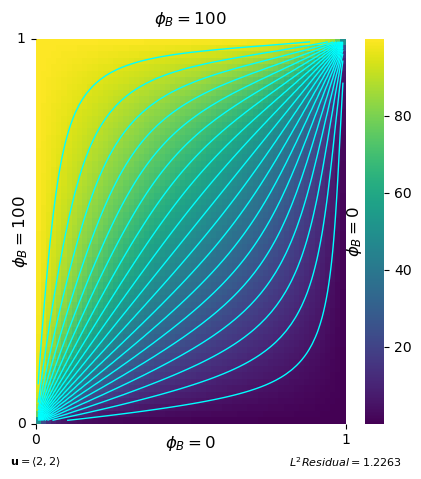

In [4]:
s = ConvectionDiffusionSolver(n_rows=60, n_cols=60)
s.construct_problem()
s.solve_problem()
s.plot()

Setting coefficients of cell 3600/3600 | Total coefficient count: [17757]

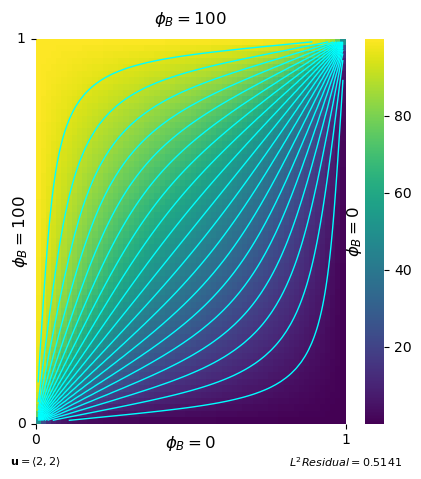

In [927]:
s = ConvectionDiffusionSolver(n_rows=60, n_cols=60, gamma=0)
s.construct_problem()
s.solve_problem()
s.plot()

Setting coefficients of cell 3600/3600 | Total coefficient count: [17757]

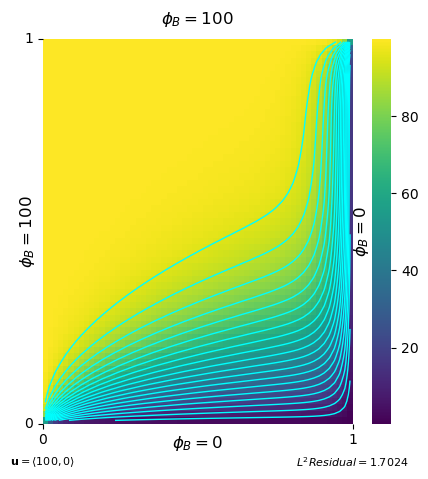

In [924]:
s = ConvectionDiffusionSolver(n_rows=60, n_cols=60, u_x=100, u_y=0, gamma=5)
s.construct_problem()
s.solve_problem()
s.plot()

Setting coefficients of cell 3600/3600 | Total coefficient count: [17757]

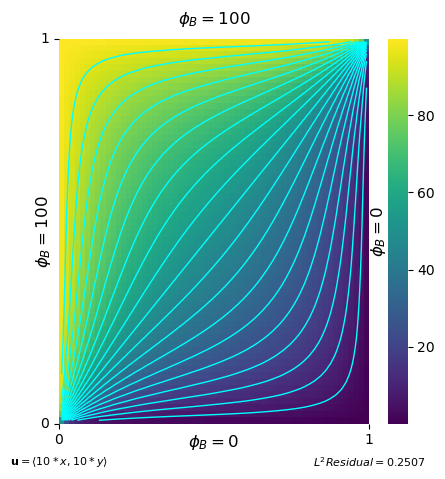

In [926]:
s = ConvectionDiffusionSolver(n_cols=60, n_rows=60, u_x=u_x, u_y=u_y)
s.construct_problem()
s.solve_problem()
s.plot()

In [971]:
u_x = sympy.Expr(1)
display(u_x, u_y)

Expr(1)

1

In [968]:
float(u_x)

TypeError: Cannot convert expression to float

In [18]:
u_x

10*x - 5.0

In [ ]:
s = ConvectionDiffusionSolver(n_cols=60, n_rows=60, u_x=u_x, u_y=u_y, gamma=0)
s.construct_problem()
s.solve_problem()
s.plot()

Setting coefficients of cell 237/3600 | Total coefficient count: [1105]

270.0*\phi_E - 270.0*\phi_N - 270.0*\phi_S + 270.0*\phi_W

57

3

AttributeError: module 'os' has no attribute 'exit'

Setting coefficients of cell 3600/3600 | Total coefficient count: [17757]

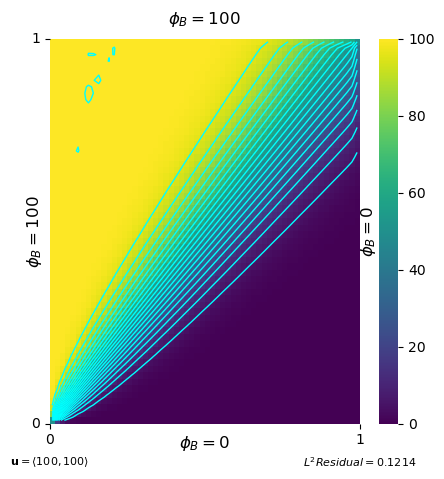

In [945]:
s = ConvectionDiffusionSolver(n_cols=60, n_rows=60, u_x=100, u_y=100, gamma=1)
s.construct_problem()
s.solve_problem()
s.plot()

In [939]:
(s._A.toarray().diagonal() == 0).sum()

29

Setting coefficients of cell 3600/3600 | Total coefficient count: [17757]

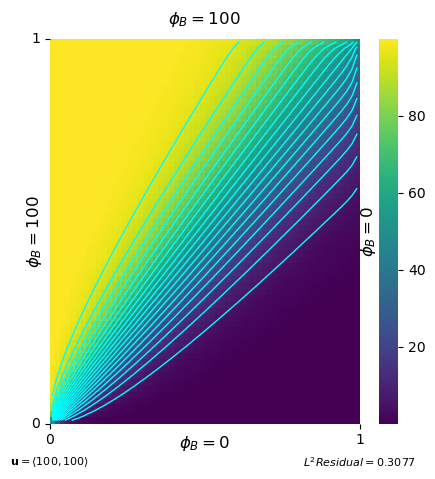

In [948]:
s = ConvectionDiffusionSolver(n_cols=60, n_rows=60, u_x=100, u_y=100, scheme="upwind")
s.construct_problem()
s.solve_problem()
s.plot()

In [876]:
x, y, z= symbols("x y z")
f = sympy.Piecewise((7 + x, x > 0), (x*y, x < 0))

In [878]:
g = z**2 + f /2

In [879]:
g

z**2 + Piecewise((x + 7, x > 0), (x*y, x < 0))/2

In [880]:
g.subs({x: 1, y: 4})

z**2 + 4

In [867]:
type(u)

int